In [80]:
r = '\033[31m'

In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import svm, datasets
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


%matplotlib inline

## 6.01 - Supervised Learning Model Comparison

Recall the "data science process."

1. Define the problem.
2. Gather the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus mostly on creating (and then comparing) many regression and classification models. Thus, we'll define the problem and gather the data for you.

### Step 1: Define the problem.

You are a data scientist with a financial services company. Specifically, you want to leverage data in order to identify potential customers.

If you are unfamiliar with "401(k)s" or "IRAs," these are two types of retirement accounts. Very broadly speaking:
- You can put money for retirement into both of these accounts.
- The money in these accounts gets invested and hopefully has a lot more money in it when you retire.
- These are a little different from regular bank accounts in that there are certain tax benefits to these accounts. Also, employers frequently match money that you put into a 401k.
- If you want to learn more about them, check out [this site](https://www.nerdwallet.com/article/ira-vs-401k-retirement-accounts).

We will tackle one regression problem and one classification problem today.
- Regression: What features best predict one's income?
- Classification: Predict whether or not one is eligible for a 401k.

Check out the data dictionary [here](http://fmwww.bc.edu/ec-p/data/wooldridge2k/401KSUBS.DES).

### NOTE: When predicting `inc`, you should pretend as though you do not have access to the `e401k`, the `p401k` variable, and the `pira` variable. When predicting `e401k`, you may use the entire dataframe if you wish.

### Step 2: Gather the data.

##### 1. Read in the data from the repository.

In [82]:
import pandas as pd

In [83]:
df = pd.read_csv('401ksubs.csv')
df.head()

,e401k,inc,marr,male,age,fsize,nettfa,p401k,pira,incsq,agesq
0,0,13.170,0,0,40,1,4.575,0,1,173.4489,1600
1,1,61.230,0,1,35,1,154.000,1,0,3749.1130,1225
2,0,12.858,1,0,44,2,0.000,0,0,165.3282,1936
3,0,98.880,1,1,44,2,21.800,0,0,9777.2540,1936
4,0,22.614,0,0,53,1,18.450,0,0,511.3930,2809


In [84]:
df.describe()

,e401k,inc,marr,male,age,fsize,nettfa,p401k,pira,incsq,agesq
count,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000
mean,0.392129,39.254641,0.628571,0.204420,41.080216,2.885067,19.071675,0.276226,0.254340,2121.192483,1793.652722
std,0.488252,24.090002,0.483213,0.403299,10.299517,1.525835,63.963838,0.447154,0.435513,3001.469424,895.648841
min,0.000000,10.008000,0.000000,0.000000,25.000000,1.000000,-502.302000,0.000000,0.000000,100.160100,625.000000
25%,0.000000,21.660000,0.000000,0.000000,33.000000,2.000000,-0.500000,0.000000,0.000000,469.155600,1089.000000
50%,0.000000,33.288000,1.000000,0.000000,40.000000,3.000000,2.000000,0.000000,0.000000,1108.091000,1600.000000
75%,1.000000,50.160000,1.000000,0.000000,48.000000,4.000000,18.449500,1.000000,1.000000,2516.025500,2304.000000
max,1.000000,199.041000,1.000000,1.000000,64.000000,13.000000,1536.798000,1.000000,1.000000,39617.320000,4096.000000


In [85]:
df.isnull().sum()

e401k     0
inc       0
marr      0
male      0
age       0
fsize     0
nettfa    0
p401k     0
pira      0
incsq     0
agesq     0
dtype: int64

##### 2. What are 2-3 other variables that, if available, would be helpful to have?

Partner Income - A deciding factor might be whether or not there is enough investable income.
Partner Status - Does the partner have a 401k/ROTH as well? It could be one is more hevaily invested

##### 3. Suppose a peer recommended putting `race` into your model in order to better predict who to target when advertising IRAs and 401(k)s. Why would this be an unethical decision?

It can be used as justiifcation to deny certain groups applications based on their race using the data gathered. Or extrapolate other race based agendas using the data.

## Step 3: Explore the data.

##### 4. When attempting to predict income, which feature(s) would we reasonably not use? Why?


Reasonable 
    
- Age (As age increases senority and salary generally grows)
- Net Assesets (Assessts are indiciative of general wealth or investments)
- 401k or Roth (Generally people who have disposable income for retirement make more)


Unreasonable 
    
- Marriage (Has no bearing on income)
- Family Size (Has no bearing on income)


##### 5. What two variables have already been created for us through feature engineering? Come up with a hypothesis as to why subject-matter experts may have done this.
> This need not be a "statistical hypothesis." Just brainstorm why SMEs might have done this!

 Income sq and age sq. I believe these were featured engineered so to scale up our coefficents or if there is a negative relationship to negate it. 

##### 6. Looking at the data dictionary, one variable description appears to be an error. What is this error, and what do you think the correct value would be?

income and age (not squared) still have ^2 descriptions. They should be removed. 

## Step 4: Model the data. (Part 1: Regression Problem)

Recall:
- Problem: What features best predict one's income?
- When predicting `inc`, you should pretend as though you do not have access to the `e401k`, the `p401k` variable, and the `pira` variable.

##### 7. List all modeling tactics we've learned that could be used to solve a regression problem (as of Wednesday afternoon of Week 6). For each tactic, identify whether it is or is not appropriate for solving this specific regression problem and explain why or why not.


    
- Multiple Linear Regression Model
    
- Genearlized Linear Models
 
- SGD Regressor


##### 8. Regardless of your answer to number 7, fit at least one of each of the following models to attempt to solve the regression problem above:
    - a multiple linear regression model
    - a $k$-nearest neighbors model
    - a decision tree
    - a set of bagged decision trees
    - a random forest
    - an Adaboost model
    - a support vector regressor
    
> As always, be sure to do a train/test split! In order to compare modeling techniques, you should use the same train-test split on each. I recommend setting a random seed here.

> You may find it helpful to set up a pipeline to try each modeling technique, but you are not required to do so!

In [86]:
features = ['marr', 'male', 'age', 'fsize', 'nettfa','agesq']
y = df['inc']
X = df[features]

In [87]:
# Note: I removed inc^2 from the features as it was making our models too predictive. And since we are predicting income, inc^2 would be cheating our models

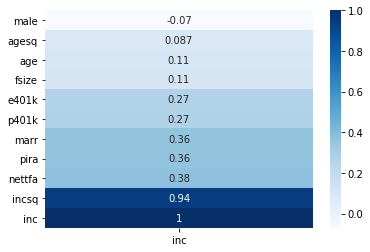

In [88]:
sns.heatmap(df.corr()[['inc']].sort_values('inc'), cmap ='Blues', annot=True);

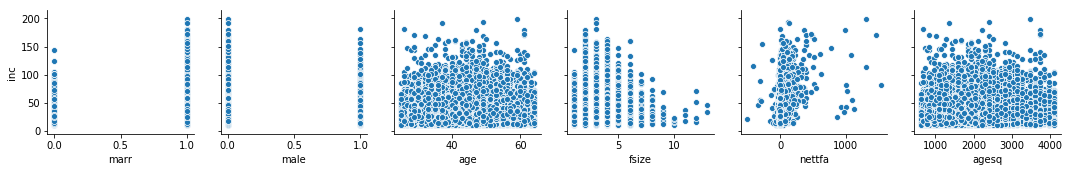

In [89]:
sns.pairplot(data=df, y_vars=['inc'], x_vars=features );

In [90]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [91]:
#Standard Scaler
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


## Multiple Linear Regression

In [92]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(r+ 'Linear Regression Test Scores', round(lr.score(X_test, y_test),4))

Linear Regression Test Scores 0.2617


## K Nearest Neighbors Regressor

In [93]:
knn = KNeighborsRegressor(n_neighbors=40)
knn.fit(X_train, y_train)
knnpredict = knn.predict(X_test)
print(r +'KNN Regressor Test Scores', round(knn.score(X_test, y_test),4))

KNN Regressor Test Scores 0.3569


## Decision Tree Regressor

In [94]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr.score(X_test, y_test)
print(r +'Decision Tree Regressor Test Scores', round(dtr.score(X_test, y_test),4))

Decision Tree Regressor Test Scores -0.256


## Bagged Regressor

In [95]:
bdt = BaggingRegressor(n_estimators=100)
bdt.fit(X_train, y_train)
print(r +'Bagging Regressor Test Scores', round(bdt.score(X_test, y_test),4))  

Bagging Regressor Test Scores 0.2962


## Random Forest Regressor

In [96]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
print(r +'Random Forest Test Scores', round(rf.score(X_test, y_test),4))   

Random Forest Test Scores 0.3039


## Adaboost Regressor

In [97]:
am = AdaBoostRegressor(n_estimators=100)
am.fit(X_train, y_train)
print(r +'Adaboost Test Scores', round(am.score(X_test, y_test),4))   
#Overfitting

Adaboost Test Scores 0.0048


## SV Regressor

In [98]:
svr = svm.SVR(kernel='rbf')
svr.fit(X_train, y_train)

print(r +'SV Regressor Test Scores', round(svr.score(X_test, y_test),4))   

SV Regressor Test Scores 0.3029


##### 9. What is bootstrapping?

Bootstrapping is a resampling technique WITH replacement. It requires taking from original data and calculating statistics out of the new resampled data. 

##### 10. What is the difference between a decision tree and a set of bagged decision trees? Be specific and precise!

 A bagged decision tree will run several models in parallel with bootstrapped samples and aggregate their decisions/predictions.  

##### 11. What is the difference between a set of bagged decision trees and a random forest? Be specific and precise!

A random forest is also bagged like decision trees, however random forests uses a random column to split on while a decision tree uses impurity (usually gini) 

##### 12. Why might a random forest be superior to a set of bagged decision trees?
> Hint: Consider the bias-variance tradeoff.

 Bagged Decision trees are often heavily overfit to the data they are trained on and doesn't take well to new data. This is because when it is trained to fit all samples of the training set. 

## Step 5: Evaluate the model. (Part 1: Regression Problem)

##### 13. Using RMSE, evaluate each of the models you fit on both the training and testing data.

In [99]:
print(r+'Linear Regression',  mean_squared_error(y_test, lr.predict(X_test)), 'Train',  mean_squared_error(y_train, lr.predict(X_train))   )
print(r+'KNN', mean_squared_error(y_test, knn.predict(X_test)),'Train',  mean_squared_error(y_train, knn.predict(X_train))    )
print(r+'Decision Tree', mean_squared_error(y_test,dtr.predict(X_test)),'Train' ,  mean_squared_error(y_train, dtr.predict(X_train))    )
print(r+'Bagged', mean_squared_error(y_test,bdt.predict(X_test)),'Train' ,  mean_squared_error(y_train, bdt.predict(X_train))    )
print(r+'Random Forest', mean_squared_error(y_test,rf.predict(X_test)),'Train' ,  mean_squared_error(y_train, rf.predict(X_train))    )
print(r+'AdaBoost', mean_squared_error(y_test,am.predict(X_test)),'Train' ,  mean_squared_error(y_train, am.predict(X_train))   )
print(r+'SVR', mean_squared_error(y_test,svr.predict(X_test)),'Train' ,  mean_squared_error(y_train, svr.predict(X_train))    )

Linear Regression 440.21171320747357 Train 403.4647903128399
KNN 383.4522386510241 Train 351.8649927772831
Decision Tree 748.8695683370868 Train 5.2814387627787935
Bagged 419.64061842411724 Train 59.17585207715378
Random Forest 415.0333257835724 Train 59.431232917321935
AdaBoost 593.3667039447588 Train 549.4659334994117
SVR 415.62149464647445 Train 392.1135742111809


##### 14. Based on training RMSE and testing RMSE, is there evidence of overfitting in any of your models? Which ones?

Decision Tree is highly overfit with an RMSE score of only 5.28 on Training and 737 on testing.  

##### 15. Based on everything we've covered so far, if you had to pick just one model as your final model to use to answer the problem in front of you, which one model would you pick? Defend your choice.

 I would most likely go with KNN for this particular Regression. The reasoning is that the RMSE for both tarining and test are similar. Meaning we aren't overfitting too much and yet it yields the best testing results for this model. In addition, we see the test accuracy pull in the best results 

##### 16. Suppose you wanted to improve the performance of your final model. Brainstorm 2-3 things that, if you had more time, you would attempt.

I would try hyperparameters, and tweaking n_neighbors. I might also look into ways of changing Train test split sizes

## Step 4: Model the data. (Part 2: Classification Problem)

Recall:
- Problem: Predict whether or not one is eligible for a 401k.
- When predicting `e401k`, you may use the entire dataframe if you wish.

##### 17. While you're allowed to use every variable in your dataframe, mention at least one disadvantage of using `p401k` in your model.

If someone is paricipating in 401k they are almost assuredly eligible for 401k eligible. It would be skew our models as they are directly correlated 

##### 18. List all modeling tactics we've learned that could be used to solve a classification problem (as of Wednesday afternoon of Week 6). For each tactic, identify whether it is or is not appropriate for solving this specific classification problem and explain why or why not.



- KNN
- Logistic
- Decisions Trees
- SVM
- Bagging
- Random Forest



##### 19. Regardless of your answer to number 18, fit at least one of each of the following models to attempt to solve the classification problem above:
    - a logistic regression model
    - a $k$-nearest neighbors model
    - a decision tree
    - a set of bagged decision trees
    - a random forest
    - an Adaboost model
    - a support vector classifier
    
> As always, be sure to do a train/test split! In order to compare modeling techniques, you should use the same train-test split on each. I recommend using a random seed here.

> You may find it helpful to set up a pipeline to try each modeling technique, but you are not required to do so!

In [100]:
features = ['marr', 'male', 'age', 'fsize', 'nettfa','agesq', 'inc', 'pira', 'incsq', 'agesq']
y = df['e401k']
X = df[features]

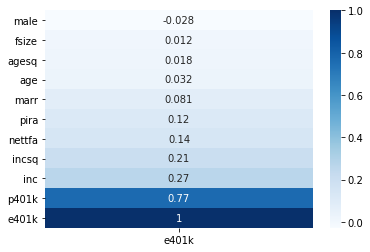

In [101]:
sns.heatmap(df.corr()[['e401k']].sort_values('e401k'), cmap ='Blues', annot=True);

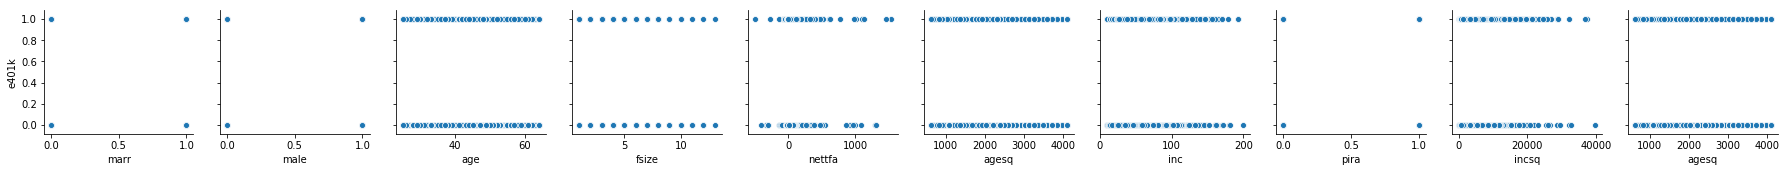

In [102]:
sns.pairplot(data=df, y_vars=['e401k'], x_vars=features );

In [103]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [104]:
#Standard Scaler
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


## Logistic Regression

In [105]:
logr = LogisticRegression()
logr.fit(X_train, y_train)
print(r+ 'Logistic Regression Test Scores', round(logr.score(X_test, y_test),4))

Logistic Regression Test Scores 0.6555


## K Nearest Neighbors Classifier

In [106]:
knnc = KNeighborsClassifier(n_neighbors=40)
knnc.fit(X_train, y_train)
print(r +'KNN Class Test Scores', round(knnc.score(X_test, y_test),4))

KNN Class Test Scores 0.6654


## Decision Tree 

In [107]:
dtr = DecisionTreeClassifier()
dtr.fit(X_train, y_train)
dtr.score(X_test, y_test)
print(r +'Decision Tree Regressor Test Scores', round(dtr.score(X_test, y_test),4))

Decision Tree Regressor Test Scores 0.586


## Bagged 

In [108]:
bdt = BaggingClassifier(n_estimators=100)
bdt.fit(X_train, y_train)
print(r +'Bagging Regressor Test Scores', round(bdt.score(X_test, y_test),4))  

Bagging Regressor Test Scores 0.6585


## Random Forest 

In [109]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
print(r +'Random Forest Test Scores', round(rf.score(X_test, y_test),4))   

Random Forest Test Scores 0.6619


## Adaboost 

In [110]:
am = AdaBoostClassifier(n_estimators=100)
am.fit(X_train, y_train)
print(r +'Adaboost Test Scores', round(am.score(X_test, y_test),4))   
#Overfitting

Adaboost Test Scores 0.6809


## SVC

In [111]:
svc = svm.SVC(kernel='rbf')
svc.fit(X_train, y_train)

print(r +'SVC Regressor Test Scores', round(svc.score(X_test, y_test),4))   

SVC Regressor Test Scores 0.6736


## Step 5: Evaluate the model. (Part 2: Classfication Problem)

##### 20. Suppose our "positive" class is that someone is eligible for a 401(k). What are our false positives? What are our false negatives?

 Fasle positives are what the model would claim are eligible for 401k. However, a false negative would classify people saying they aren't elgiible but in fact were.

##### 21. In this specific case, would we rather minimize false positives or minimize false negatives? Defend your choice.

 We would mostly want to maximize our sensitivity rate. Meaning we don't want any false negatives. A person enrolled in their 401k only adds to their own retriment and potential for investment. However, if a person is unable to save for their retirement that might a worse scenario.  

##### 22. Suppose we wanted to optimize for the answer you provided in problem 21. Which metric would we optimize in this case?

Sensitivity 

##### 23. Suppose that instead of optimizing for the metric in problem 21, we wanted to balance our false positives and false negatives using `f1-score`. Why might [f1-score](https://en.wikipedia.org/wiki/F1_score) be an appropriate metric to use here?

Because neither false positives or false negatives truly outweigh each other. Technically, we might want to minimize both and focus on accuracy. 

##### 24. Using f1-score, evaluate each of the models you fit on both the training and testing data.

In [112]:
print(r+'Logistic Regression',  f1_score(y_test, logr.predict(X_test)), 'Train',  f1_score(y_train, logr.predict(X_train))   )
print(r+'KNN', f1_score(y_test, knnc.predict(X_test)),'Train',  f1_score(y_train, knnc.predict(X_train))    )
print(r+'Decision Tree', f1_score(y_test,dtr.predict(X_test)),'Train' ,  f1_score(y_train, dtr.predict(X_train))    )
print(r+'Bagged', f1_score(y_test,bdt.predict(X_test)),'Train' ,  f1_score(y_train, bdt.predict(X_train))    )
print(r+'Random Forest', f1_score(y_test,rf.predict(X_test)),'Train' ,  f1_score(y_train, rf.predict(X_train))    )
print(r+'AdaBoost', f1_score(y_test,am.predict(X_test)),'Train' ,  f1_score(y_train, am.predict(X_train))   )
print(r+'SVC', f1_score(y_test,svc.predict(X_test)),'Train' ,  f1_score(y_train, svc.predict(X_train))    )

Logistic Regression 0.47121111846459296 Train 0.48144128500108535
KNN 0.44729344729344733 Train 0.4816176470588236
Decision Tree 0.4707828004410143 Train 1.0
Bagged 0.5257485029940121 Train 1.0
Random Forest 0.5236938031591737 Train 1.0
AdaBoost 0.5525997581620313 Train 0.5775015039101665
SVC 0.45342960288808665 Train 0.47799337434926653


##### 25. Based on training f1-score and testing f1-score, is there evidence of overfitting in any of your models? Which ones?

 The most overfitting occurs with trees. Decision Trees, Bagged Decision Trees, and Random forest all return with training scores of 1 for F1 Scores. Means they are highly overfitted on their models  

##### 26. Based on everything we've covered so far, if you had to pick just one model as your final model to use to answer the problem in front of you, which one model would you pick? Defend your choice.

 I would likely choose Adaboost for our model. It has the highest accuracy and also has the best F1 Score of our models.

##### 27. Suppose you wanted to improve the performance of your final model. Brainstorm 2-3 things that, if you had more time, you would attempt.

 I would try hyperparameters, and tweaking n_neighbors. I might also look into ways of changing Train test split sizes 

<font color='red'>  </font>

## Step 6: Answer the problem.

##### BONUS: Briefly summarize your answers to the regression and classification problems. Be sure to include any limitations or hesitations in your answer.

- Regression: What features best predict one's income?
- Classification: Predict whether or not one is eligible for a 401k.

Classification KNN regrssor worked best. Whereas Adaboost worked best for Classification. 